In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb  # Import rgba2rgb to handle 4-channel images
from skimage.feature import hog
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier




In [2]:
# Directory of the Mango Fruit dataset
data_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS/SenMangoFruitDDS_bgremoved'  # You can switch to _original if needed
print(os.listdir(data_dir))

# Get class names from the directory structure
class_names = os.listdir(data_dir)

# Prepare a list to store filenames and labels
data = []

# Iterate through each class folder to collect filenames and their labels
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):  # Check if it is a directory
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust file extensions if necessary
                data.append((os.path.join(class_name, filename), class_name))

# Create a DataFrame
df = pd.DataFrame(data, columns=['filename', 'label'])

# Show the first few rows of the DataFrame
print(df.head())


['Anthracnose', 'Alternaria', 'Healthy', 'Stem and Rot', 'Black Mould Rot']
                          filename        label
0  Anthracnose/Anthracnose_002.jpg  Anthracnose
1  Anthracnose/Anthracnose_066.jpg  Anthracnose
2  Anthracnose/Anthracnose_057.jpg  Anthracnose
3  Anthracnose/Anthracnose_096.jpg  Anthracnose
4  Anthracnose/Anthracnose_106.jpg  Anthracnose


In [3]:
# Split the data into training and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])  # 70% train, 30% temp

# Split temp into validation and test
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])  # 15% val, 15% test

# Print out the sizes of the splits
print(f"Training samples: {len(train_df)}, Validation samples: {len(validation_df)}, Testing samples: {len(test_df)}")


Training samples: 586, Validation samples: 126, Testing samples: 126


In [4]:
# Create ImageDataGenerators for train, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')  # Data augmentation for training

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for validation and test

# Generators for training
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generators for validation
validation_generator = val_test_datagen.flow_from_dataframe(
    validation_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generators for testing
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 586 validated image filenames belonging to 5 classes.
Found 126 validated image filenames belonging to 5 classes.
Found 126 validated image filenames belonging to 5 classes.


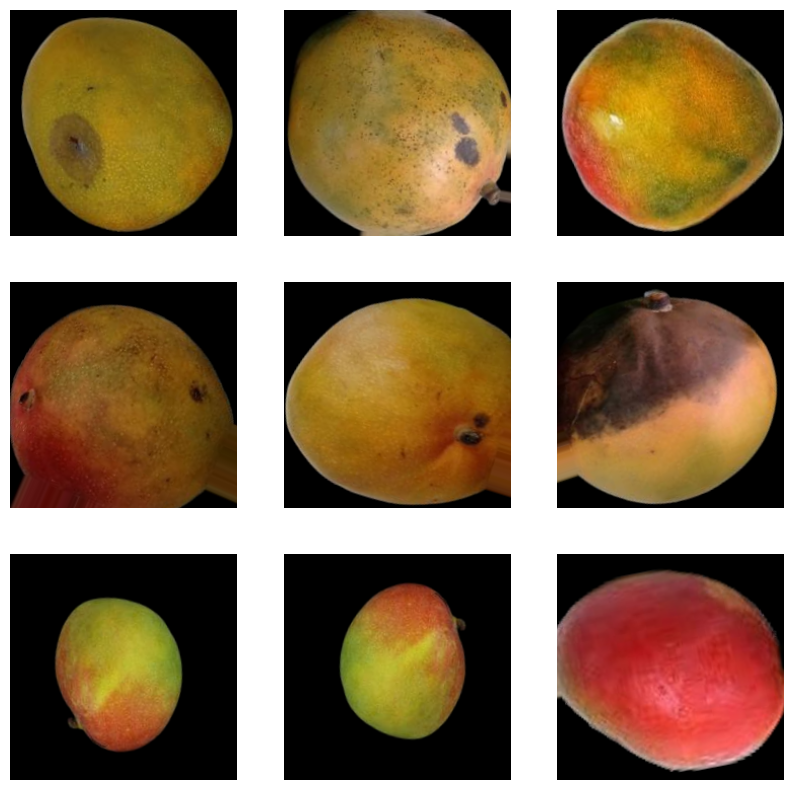

In [5]:
# Visualize a batch of images
sample_batch = next(train_generator)  # Get one batch of training images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images from the batch
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_batch[0][i])
    plt.axis('off')
plt.show()


In [6]:
# Function to extract HOG features from an image path
def extract_hog_features(image_path):
    image = imread(image_path)
    
    # If the image has 4 channels (RGBA), convert it to RGB
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    
    # Convert the image to grayscale
    image_gray = rgb2gray(image)
    
    # Extract HOG features
    features = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
    return features

# Function to extract HOG features and pad/truncate to a fixed length
def extract_and_pad_hog_features(image_filenames):
    hog_features = []
    max_length = 2916  # HOG features length for 224x224 image with (16, 16) pixels_per_cell
    
    for f in tqdm(image_filenames):
        features = extract_hog_features(os.path.join(data_dir, f))
        
        # Padding or truncating to ensure all feature vectors have the same length
        if len(features) < max_length:
            features = np.pad(features, (0, max_length - len(features)), 'constant')
        elif len(features) > max_length:
            features = features[:max_length]
        
        hog_features.append(features)
    
    return np.array(hog_features)

In [7]:
# Extract HOG features for training, validation, and testing datasets
train_features = extract_and_pad_hog_features(train_df['filename'])
validation_features = extract_and_pad_hog_features(validation_df['filename'])
test_features = extract_and_pad_hog_features(test_df['filename'])


100%|██████████| 126/126 [00:02<00:00, 51.91it/s]


In [8]:
# Convert labels into numerical form
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
validation_labels = label_encoder.transform(validation_df['label'])
test_labels = label_encoder.transform(test_df['label'])


In [9]:
# Function to train a model and evaluate it on validation data
def train_and_evaluate(model, train_features, train_labels, validation_features, validation_labels):
    # Train the model
    model.fit(train_features, train_labels)
    
    # Make predictions on validation data
    validation_preds = model.predict(validation_features)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(validation_labels, validation_preds)
    precision = precision_score(validation_labels, validation_preds, average='weighted')
    recall = recall_score(validation_labels, validation_preds, average='weighted')
    f1 = f1_score(validation_labels, validation_preds, average='weighted')
    
    # Return the metrics as a tuple
    return accuracy, precision, recall, f1

In [10]:
# Train Naive Bayes classifier on HOG features
nb_classifier = GaussianNB()
nb_classifier.fit(train_features, train_labels)

# Evaluate Naive Bayes using the train_and_evaluate function
nb_metrics = train_and_evaluate(nb_classifier, train_features, train_labels, validation_features, validation_labels)

# Display Naive Bayes results
print("Naive Bayes Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*nb_metrics))


Naive Bayes Metrics: Accuracy: 0.47, Precision: 0.50, Recall: 0.47, F1-Score: 0.47


In [11]:
# 1. SVM Model
svm_model = SVC(kernel='linear', random_state=42)

# Evaluate SVM using the train_and_evaluate function
svm_metrics = train_and_evaluate(svm_model, train_features, train_labels, validation_features, validation_labels)

# Display SVM results
print("SVM Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*svm_metrics))


SVM Metrics: Accuracy: 0.45, Precision: 0.48, Recall: 0.45, F1-Score: 0.46


In [12]:
# 2. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluate Random Forest using the train_and_evaluate function
rf_metrics = train_and_evaluate(rf_model, train_features, train_labels, validation_features, validation_labels)

# Display Random Forest results
print("Random Forest Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*rf_metrics))


Random Forest Metrics: Accuracy: 0.51, Precision: 0.54, Recall: 0.51, F1-Score: 0.52


In [13]:
# 3. K-Nearest Neighbors Model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Evaluate KNN using the train_and_evaluate function
knn_metrics = train_and_evaluate(knn_model, train_features, train_labels, validation_features, validation_labels)

# Display KNN results
print("KNN Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*knn_metrics))


KNN Metrics: Accuracy: 0.52, Precision: 0.57, Recall: 0.52, F1-Score: 0.53


In [14]:
# Import the DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# 4. Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)

# Evaluate Decision Tree using the train_and_evaluate function
dt_metrics = train_and_evaluate(dt_model, train_features, train_labels, validation_features, validation_labels)

# Display Decision Tree results
print("Decision Tree Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*dt_metrics))


Decision Tree Metrics: Accuracy: 0.43, Precision: 0.43, Recall: 0.43, F1-Score: 0.43


In [15]:
# Summarize and compare metrics of different models
models = ['Naive Bayes', 'SVM', 'Random Forest', 'KNN', 'Decision Tree'] 
metrics = [nb_metrics, svm_metrics, rf_metrics, knn_metrics, dt_metrics] 

# Display a comparison table
for i, model_name in enumerate(models):
    print(f"{model_name} Metrics: Accuracy: {metrics[i][0]:.2f}, Precision: {metrics[i][1]:.2f}, Recall: {metrics[i][2]:.2f}, F1-Score: {metrics[i][3]:.2f}")


Naive Bayes Metrics: Accuracy: 0.47, Precision: 0.50, Recall: 0.47, F1-Score: 0.47
SVM Metrics: Accuracy: 0.45, Precision: 0.48, Recall: 0.45, F1-Score: 0.46
Random Forest Metrics: Accuracy: 0.51, Precision: 0.54, Recall: 0.51, F1-Score: 0.52
KNN Metrics: Accuracy: 0.52, Precision: 0.57, Recall: 0.52, F1-Score: 0.53
Decision Tree Metrics: Accuracy: 0.43, Precision: 0.43, Recall: 0.43, F1-Score: 0.43


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [17]:
from tensorflow.keras import Input

# Define CNN model architecture
def create_basic_cnn(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices)):
    model = Sequential([
        Input(shape=input_shape),  # Define input shape using Input layer
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize the CNN model
cnn_model = create_basic_cnn()


In [18]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=20,  # Adjust epochs as necessary
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose = True
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729968969.459571      73 service.cc:145] XLA service 0x7cbde40061c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729968969.459643      73 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/19 ━━━━━━━━━━━━━━━━━━━━ 3:02 10s/step - accuracy: 0.3125 - loss: 1.5932

I0000 00:00:1729968974.858326      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.2879 - loss: 1.7945 - val_accuracy: 0.4286 - val_loss: 1.2333
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.4463 - loss: 1.2304 - val_accuracy: 0.5556 - val_loss: 1.1058
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.5718 - loss: 1.0314 - val_accuracy: 0.6429 - val_loss: 0.9477
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.6039 - loss: 0.9066 - val_accuracy: 0.5873 - val_loss: 0.9625
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.6422 - loss: 0.8607 - val_accuracy: 0.6349 - val_loss: 0.9243
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.6626 - loss: 0.8367 - val_accuracy: 0.6587 - val_loss: 0.8621
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.6920 - loss: 0.7692 - val_accuracy: 0.6190 - val_loss: 0.8604
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.6581 - loss: 0.7950 - val_accuracy: 0.6746 - val

In [19]:
# Evaluate on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
y_pred = cnn_model.predict(test_generator)
y_pred_labels = y_pred.argmax(axis=1)

# Get true labels from the test set
true_labels = test_generator.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7765 - loss: 0.6072
Test Accuracy: 0.75
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


In [20]:
# Performance metrics
test_precision = precision_score(true_labels, y_pred_labels, average='macro')
test_recall = recall_score(true_labels, y_pred_labels, average='macro')
test_f1 = f1_score(true_labels, y_pred_labels, average='macro')

# Print classification report and metrics
print("Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


Classification Report:
                  precision    recall  f1-score   support

     Alternaria       0.58      0.76      0.66        25
    Anthracnose       0.79      0.79      0.79        19
Black Mould Rot       0.68      0.54      0.60        28
        Healthy       0.84      0.87      0.86        31
   Stem and Rot       0.90      0.78      0.84        23

       accuracy                           0.75       126
      macro avg       0.76      0.75      0.75       126
   weighted avg       0.76      0.75      0.75       126

Test Precision: 0.76
Test Recall: 0.75
Test F1-Score: 0.75


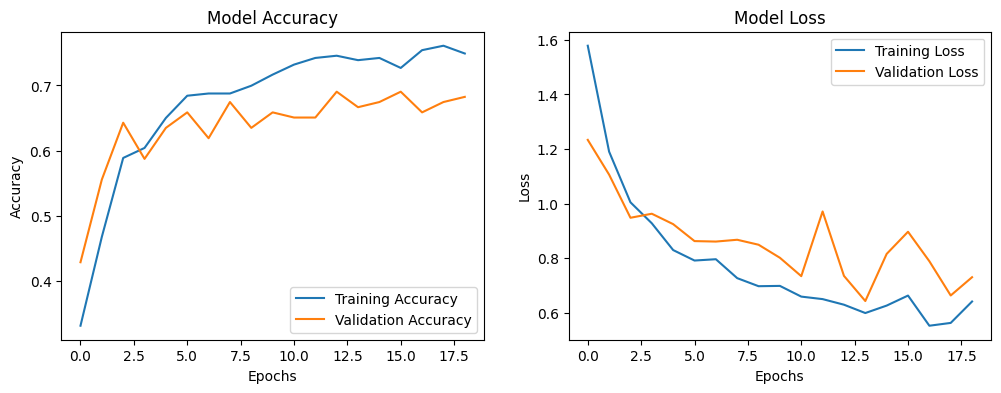

In [21]:
# Plotting training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [22]:
# Save the trained model to a file
cnn_model.save('fruit_disease_cnn.h5')  # Save as a .h5 file


In [23]:
# Load the saved CNN model
loaded_model = tf.keras.models.load_model('fruit_disease_cnn.h5')


In [24]:
import os

# List all files in the working directory
files = os.listdir('/kaggle/working')
print("Files in working directory:", files)


Files in working directory: ['__notebook__.ipynb', 'fruit_disease_cnn.h5']


In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths for both dataset folders
base_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS'
bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_bgremoved')  # Images with background
no_bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_original')  # Images without background

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators for both datasets
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2, 
                             rotation_range=20, 
                             zoom_range=0.2, 
                             horizontal_flip=True)

# Load background images
bg_train_generator = datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

bg_val_generator = datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load background-removed images
no_bg_train_generator = datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

no_bg_val_generator = datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Combine the background and background-removed datasets
def combine_generators(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)
        yield np.concatenate((x1, x2)), np.concatenate((y1, y2))

train_generator = combine_generators(bg_train_generator, no_bg_train_generator)
validation_generator = combine_generators(bg_val_generator, no_bg_val_generator)

# Define a simple CNN model
def create_basic_cnn(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize the CNN model for leaf disease
cnn_model = create_basic_cnn(num_classes=len(bg_train_generator.class_indices))

# Add an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a custom callback for verbose logging
class VerboseLogging(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training - Batch {batch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

    def on_val_batch_end(self, batch, logs=None):
        print(f"Validation - Batch {batch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Calculate steps per epoch and validation steps
train_steps = min(bg_train_generator.samples // BATCH_SIZE, no_bg_train_generator.samples // BATCH_SIZE)
val_steps = min(bg_val_generator.samples // BATCH_SIZE, no_bg_val_generator.samples // BATCH_SIZE)

# Train the model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_steps,  # Updated to ensure no repetitions
    validation_data=validation_generator,
    validation_steps=val_steps,  # Updated to ensure no repetitions
    epochs=20,
    callbacks=[early_stopping, VerboseLogging()]
)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, steps=val_steps)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 672 images belonging to 5 classes.
Found 166 images belonging to 5 classes.
Found 691 images belonging to 5 classes.
Found 171 images belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
Training - Batch 1: Loss: 1.6043, Accuracy: 0.2188
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2:28 7s/step - accuracy: 0.2188 - loss: 1.6043Training - Batch 2: Loss: 2.8808, Accuracy: 0.1875
Training - Batch 3: Loss: 2.5161, Accuracy: 0.1979
 3/21 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.2014 - loss: 2.3337Training - Batch 4: Loss: 2.2983, Accuracy: 0.2031
 4/21 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - accuracy: 0.2018 - loss: 2.3249Training - Batch 5: Loss: 2.1613, Accuracy: 0.1969
 5/21 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.2008 - loss: 2.2921Training - Batch 6: Loss: 2.0686, Accuracy: 0.2057
 6/21 ━━━━━━━━━━━━━━━━━━━━ 10s 710ms/step - accuracy: 0.2016 - loss: 2.2549Training - Batch 7: Loss: 2.0009, Accuracy: 0.2254
 7/21 ━━━━━━━━━━━━━━━━━━━━ 10s 727ms/step - accuracy: 0.2050 - loss: 2.2186Training - Batch 8: Loss: 1.9516, Accuracy: 0.2246
 8/21 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step - accuracy: 0.2075 - loss: 2.1852 Training - Batch 9: Loss: 1.9074, Accuracy: 0.2292
 9/21 ━━

In [26]:
# Reset generators before evaluation
bg_val_generator.reset()
no_bg_val_generator.reset()

# Collect true labels and predicted labels
y_true = []
y_pred = []

# Iterate through the validation steps
for _ in range(val_steps):
    # Get batch from background and background-removed data
    x_bg, y_bg_true = next(bg_val_generator)
    x_no_bg, y_no_bg_true = next(no_bg_val_generator)
    
    # Concatenate batches
    x_combined = np.concatenate((x_bg, x_no_bg))
    y_combined_true = np.concatenate((y_bg_true, y_no_bg_true))
    
    # Append true labels
    y_true.extend(np.argmax(y_combined_true, axis=1))
    
    # Predict using the trained model
    y_pred_prob = cnn_model.predict(x_combined)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [27]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=bg_val_generator.class_indices.keys())
print(report)


                 precision    recall  f1-score   support

     Alternaria       0.54      0.50      0.52        62
    Anthracnose       0.93      0.82      0.87        51
Black Mould Rot       0.54      0.68      0.60        68
        Healthy       0.90      0.94      0.92        77
   Stem and Rot       0.96      0.82      0.89        62

       accuracy                           0.76       320
      macro avg       0.78      0.75      0.76       320
   weighted avg       0.77      0.76      0.76       320



In [28]:
# Evaluate on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
y_pred = cnn_model.predict(test_generator)
y_pred_labels = y_pred.argmax(axis=1)

# Get true labels from the test set
true_labels = test_generator.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8279 - loss: 0.4785
Test Accuracy: 0.80
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


In [29]:
# Performance metrics
test_precision = precision_score(true_labels, y_pred_labels, average='macro')
test_recall = recall_score(true_labels, y_pred_labels, average='macro')
test_f1 = f1_score(true_labels, y_pred_labels, average='macro')

# Print classification report and metrics
print("Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


Classification Report:
                  precision    recall  f1-score   support

     Alternaria       0.70      0.56      0.62        25
    Anthracnose       0.89      0.84      0.86        19
Black Mould Rot       0.59      0.79      0.68        28
        Healthy       0.94      0.94      0.94        31
   Stem and Rot       1.00      0.87      0.93        23

       accuracy                           0.80       126
      macro avg       0.82      0.80      0.81       126
   weighted avg       0.82      0.80      0.80       126

Test Precision: 0.82
Test Recall: 0.80
Test F1-Score: 0.81


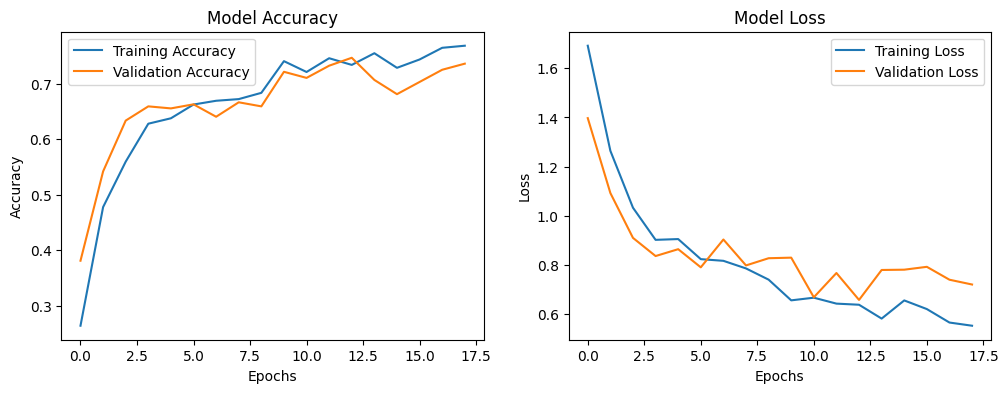

In [30]:
# Plotting training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [31]:
# Save the trained model to a file
cnn_model.save('fruit_disease_cnn.h5')  # Save as a .h5 file
